In [1]:
# %env XLA_PYTHON_CLIENT_PREALLOCATE=false
%env XLA_PYTHON_CLIENT_MEM_FRACTION=0.1
%env JAX_DEBUG_NANS=true
%env CUDA_VISIBLE_DEVICES=0

env: XLA_PYTHON_CLIENT_MEM_FRACTION=0.1
env: JAX_DEBUG_NANS=true
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import jax
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
import glob
import time
import seaborn as sns

from functools import partial
from cepnem_jax import h5_to_dict, dict_to_h5

from kfold import single_fold
from util import shuffle_data
from config import k_folds, key, time_range, l2_eps, hidden_size, batch_size

sns.set_theme()

# Set the Seaborn style
sns.set_style("dark")

# Customize the Matplotlib parameters
plt.rcParams.update({
    'figure.facecolor': '#212121',   # Background color
    'axes.facecolor': '#212121',     # Axes background color
    'axes.edgecolor': 'white',       # Axes edge color
    'axes.labelcolor': 'white',      # Axes label color
    'xtick.color': 'white',          # X tick color
    'ytick.color': 'white',          # Y tick color
    'text.color': 'white',           # Text color
    'grid.color': 'gray',            # Grid color
    'grid.alpha': 0.5,               # Grid transparency
})

In [3]:
date = time.strftime("%Y-%m-%d")

### Ventral & Head Curve variables with Offset

input_dir_path = f"/home/alex/data3/prj_rim/Decoding_Data/Finalized/DVPostReversal"
save_dir_path = f'/home/alex/data3/prj_rim/Decoding_Data/Finalized/DVPostReversal/Results'

data_source = "end"

pos_cat_key = f"dorsal_turn_{data_source}"
neg_cat_key = f"ventral_turn_{data_source}"
file_paths = glob.glob(f'{input_dir_path}/turn_predict_*.h5')
file_paths.sort()
neuron_classes = [file_path.split("/")[-1][13:-3] for file_path in file_paths]

save_file_name = f"{date}/Turn_Prediction_{data_source}"

pos_color = 'C2'
neg_color = 'C4'

### Octanol Encounter Prediction variables

# input_dir_path = "/home/alex/data3_prj_rim/Decoding_Data/OctanolReversal/PerNeuronClass"
# save_dir_path = '/home/alex/data3_prj_rim/Decoding_Data/OctanolReversal/Results'

# pos_cat_key = f"octanol_reversal_neuron_data"
# neg_cat_key = f"normal_reversal_neuron_data"
# file_paths = glob.glob(f'{input_dir_path}/decoding_*.h5')
# file_paths.sort()
# neuron_classes = [file_path.split("/")[-1][9:-3] for file_path in file_paths]

# save_file_name = f"{date}/Octanol_Reversal_Decoding"

# control_indices = [[0,1,2,3], [1,1,2,3]]


/tmp/ipykernel_2769044/1643464673.py:32: RuntimeWarning: Mean of empty slice
  positive_mean = np.nanmean(data['positive'], axis=0)
/home/alex/.local/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_2769044/1643464673.py:35: RuntimeWarning: Mean of empty slice
  negative_mean = np.nanmean(data['negative'], axis=0)


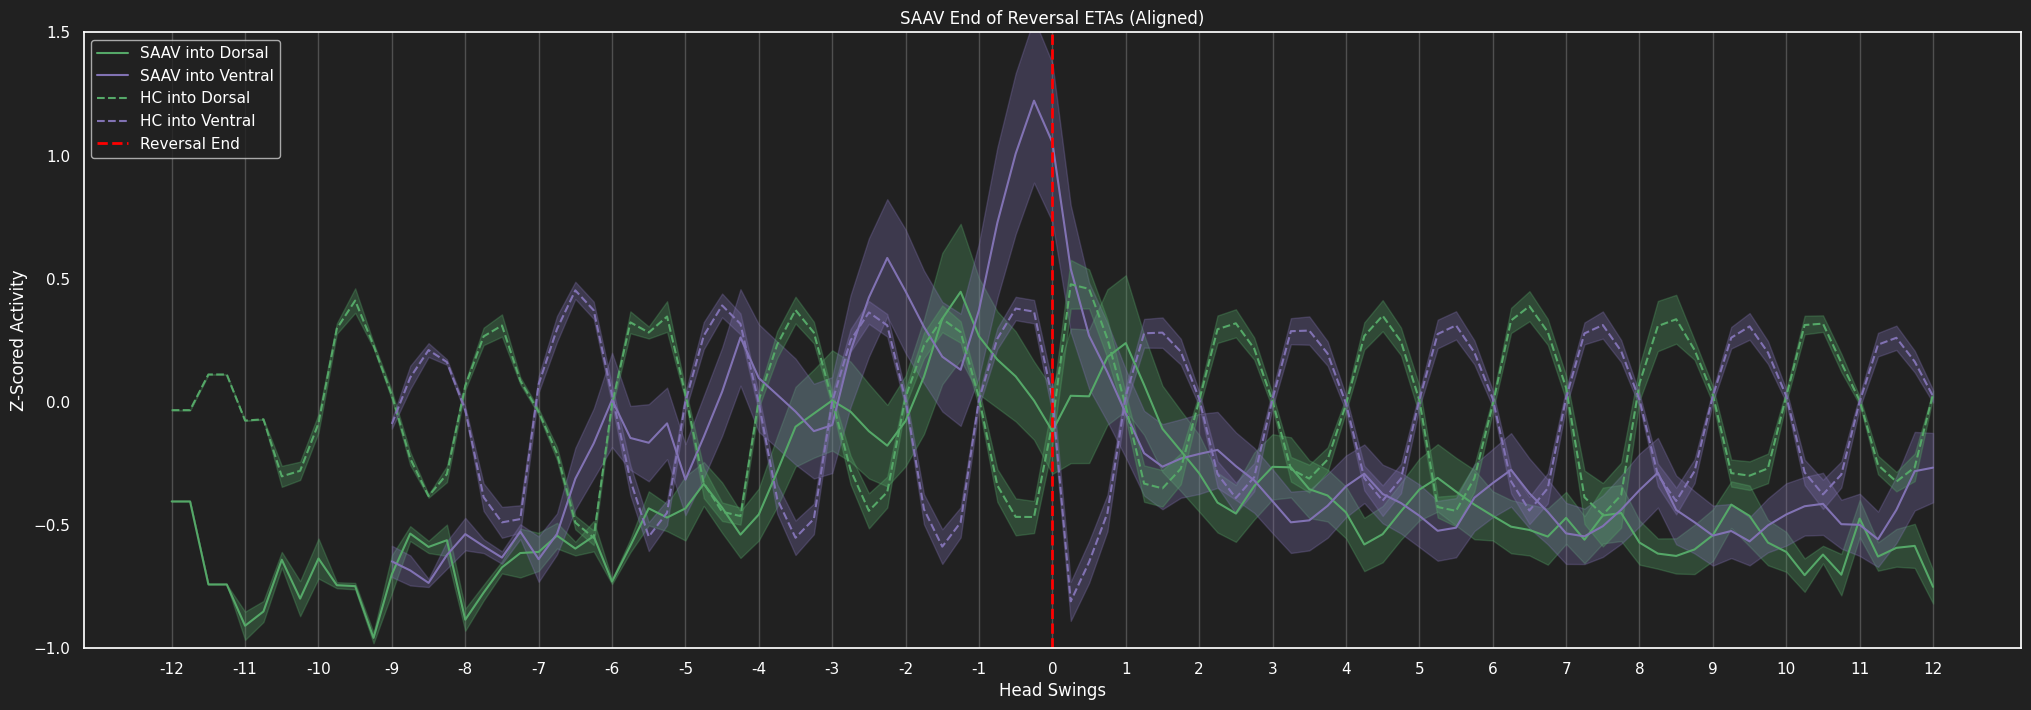

In [4]:
import pandas as pd
import numpy as np

data = {}

df = pd.read_csv('/data3/prj_rim/Decoding_Data/FlossieAligned/SAAV_dorsal.csv')
np_arr = df.to_numpy()
data['positive'] = np.zeros((np_arr.shape[0], np_arr.shape[1], 3))
data['positive'][:,:,0] = np_arr

df = pd.read_csv('/data3/prj_rim/Decoding_Data/FlossieAligned/HC_dorsal.csv')
np_arr = df.to_numpy()
data['positive'][:,:,1] = np_arr


df = pd.read_csv('/data3/prj_rim/Decoding_Data/FlossieAligned/SAAV_ventral.csv')
np_arr = df.to_numpy()

data['negative'] = np.zeros((np_arr.shape[0], np_arr.shape[1], 3))
data['negative'][:,:,0] = np_arr

df = pd.read_csv('/data3/prj_rim/Decoding_Data/FlossieAligned/HC_ventral.csv')
np_arr = df.to_numpy()
data['negative'][:,:,1] = np_arr


# data['positive'] = data['positive'][:,37:51]
# data['negative'] = data['negative'][:,37:51]


neuron = "SAAV"
positive_mean = np.nanmean(data['positive'], axis=0)
positive_std = np.nanstd(data['positive'], axis=0) / 4

negative_mean = np.nanmean(data['negative'], axis=0)
negative_std = np.nanstd(data['negative'], axis=0) / 4

plt.figure(figsize=(25, 8))

plt.plot(positive_mean[:, 0], label=f"{neuron} into Dorsal", c=pos_color)
plt.fill_between(range(len(positive_mean)), positive_mean[:, 0] - positive_std[:, 0], positive_mean[:, 0] + positive_std[:, 0], alpha=0.3, color=pos_color)

plt.plot(negative_mean[:, 0], label=f"{neuron} into Ventral", c=neg_color)
plt.fill_between(range(len(negative_mean)), negative_mean[:, 0] - negative_std[:, 0], negative_mean[:, 0] + negative_std[:, 0], alpha=0.3, color=neg_color)

plt.plot(positive_mean[:, 1], c=pos_color, linestyle='--', label="HC into Dorsal")
plt.fill_between(range(len(positive_mean)), positive_mean[:, 1] - positive_std[:, 1], positive_mean[:, 1] + positive_std[:, 1], alpha=0.3, color=pos_color)

plt.plot(negative_mean[:, 1], c=neg_color, linestyle='--', label="HC into Ventral")
plt.fill_between(range(len(negative_mean)), negative_mean[:, 1] - negative_std[:, 1], negative_mean[:, 1] + negative_std[:, 1], alpha=0.3, color=neg_color)
plt.axvline(49, color='red', linestyle='--', linewidth=2, label="Reversal End")


x = np.arange(0, len(positive_mean), 4)+1
plt.xticks(ticks=x, labels=x//4-12)

plt.legend(loc='upper left')
plt.ylabel("Z-Scored Activity")
plt.grid(axis='x')
plt.xlabel("Head Swings")
plt.title("SAAV End of Reversal ETAs (Aligned)")
plt.ylim(-1, 1.5)
plt.show()


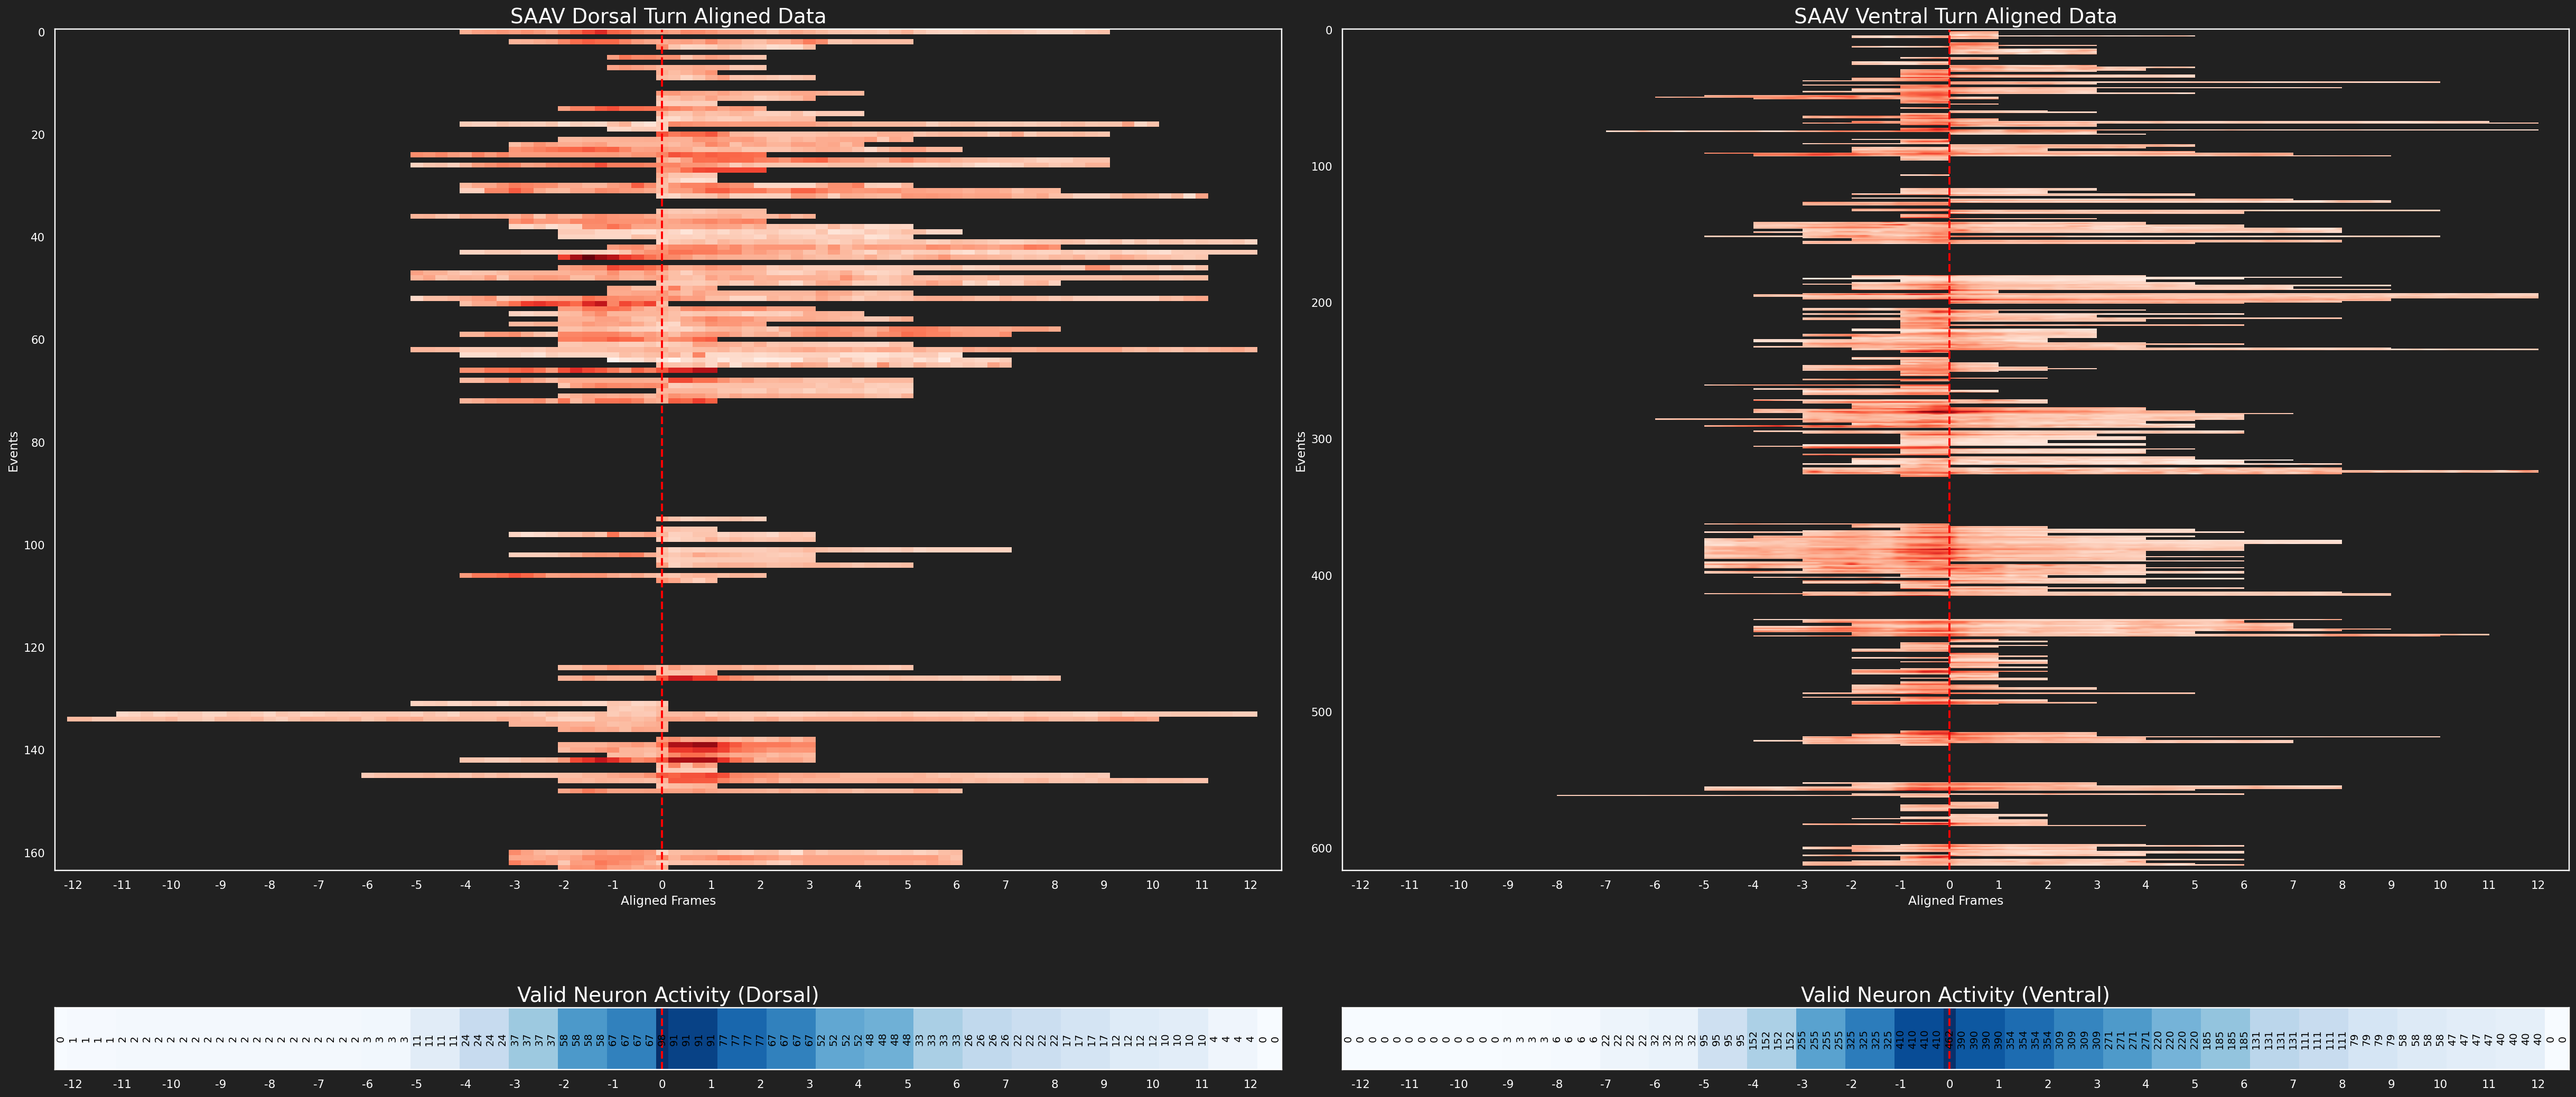

In [5]:
plt.figure(figsize=(35, 20), dpi=140)
ax1 = plt.subplot(2, 2, 1)
plt.imshow(data['positive'][:,:,0], aspect='auto', cmap="Reds")
plt.ylabel("Events")
plt.xlabel("Aligned Frames")
plt.title("SAAV Dorsal Turn Aligned Data", fontsize=20)
plt.axvline(49, color='red', linestyle='--', linewidth=2, label="Reversal End")
x = np.arange(0, data['positive'].shape[1], 4)+1
plt.xticks(ticks=x, labels=x//4-12)

ax2 = plt.subplot(2, 2, 2)
plt.imshow(data['negative'][:,:,0], aspect='auto', cmap="Reds")
plt.ylabel("Events")
plt.xlabel("Aligned Frames")
plt.title("SAAV Ventral Turn Aligned Data", fontsize=20)
plt.axvline(49, color='red', linestyle='--', linewidth=2, label="Reversal End")
x = np.arange(0, data['negative'].shape[1], 4)+1
plt.xticks(ticks=x, labels=x//4-12)


ax3 = plt.subplot(2, 2, 3, sharex=ax1)
valid_counts_dorsal = np.count_nonzero(~np.isnan(data['positive'][:,:,0]), axis=0)
plt.imshow(valid_counts_dorsal.reshape(1, -1), cmap="Blues", aspect=5)
plt.yticks([])
plt.axvline(49, color='red', linestyle='--', linewidth=2, label="Reversal End")
plt.title("Valid Neuron Activity (Dorsal)", fontsize=20)
x = np.arange(0, data['positive'].shape[1], 4)+1
plt.xticks(ticks=x, labels=x//4-12)

# Add text labels
for i, count in enumerate(valid_counts_dorsal):
    plt.text(i, 0, str(count), ha='center', va='center', color='black', fontsize=10, rotation=90)

# For the bottom right subplot (Ventral)
ax4 = plt.subplot(2, 2, 4, sharex=ax2)
valid_counts_ventral = np.count_nonzero(~np.isnan(data['negative'][:,:,0]), axis=0)
plt.imshow(valid_counts_ventral.reshape(1, -1), cmap="Blues", aspect=5)
plt.yticks([])
plt.axvline(49, color='red', linestyle='--', linewidth=2, label="Reversal End")
plt.title("Valid Neuron Activity (Ventral)", fontsize=20)
x = np.arange(0, data['negative'].shape[1], 4)+1
plt.xticks(ticks=x, labels=x//4-12)

# Add text labels
for i, count in enumerate(valid_counts_ventral):
    plt.text(i, 0, str(count), ha='center', va='center', color='black', fontsize=10, rotation=90)

plt.tight_layout()
plt.subplots_adjust(hspace=-0.3)
plt.show()

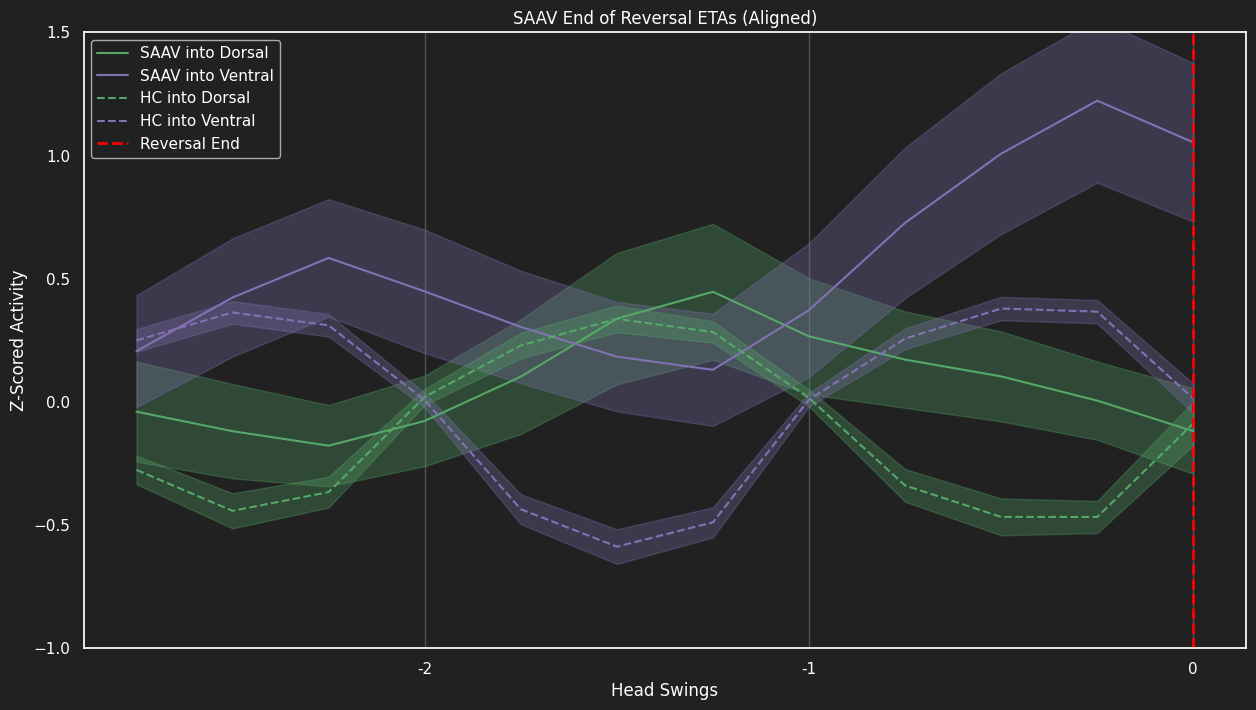

In [6]:
display_data = {}
display_data['positive'] = data['positive'][:,38:50]
display_data['negative'] = data['negative'][:,38:50]


neuron = "SAAV"
positive_mean = np.nanmean(display_data['positive'], axis=0)
positive_std = np.nanstd(display_data['positive'], axis=0) / 4

negative_mean = np.nanmean(display_data['negative'], axis=0)
negative_std = np.nanstd(display_data['negative'], axis=0) / 4

plt.figure(figsize=(15, 8))

plt.plot(positive_mean[:, 0], label=f"{neuron} into Dorsal", c=pos_color)
plt.fill_between(range(len(positive_mean)), positive_mean[:, 0] - positive_std[:, 0], positive_mean[:, 0] + positive_std[:, 0], alpha=0.3, color=pos_color)

plt.plot(negative_mean[:, 0], label=f"{neuron} into Ventral", c=neg_color)
plt.fill_between(range(len(negative_mean)), negative_mean[:, 0] - negative_std[:, 0], negative_mean[:, 0] + negative_std[:, 0], alpha=0.3, color=neg_color)

plt.plot(positive_mean[:, 1], c=pos_color, linestyle='--', label="HC into Dorsal")
plt.fill_between(range(len(positive_mean)), positive_mean[:, 1] - positive_std[:, 1], positive_mean[:, 1] + positive_std[:, 1], alpha=0.3, color=pos_color)

plt.plot(negative_mean[:, 1], c=neg_color, linestyle='--', label="HC into Ventral")
plt.fill_between(range(len(negative_mean)), negative_mean[:, 1] - negative_std[:, 1], negative_mean[:, 1] + negative_std[:, 1], alpha=0.3, color=neg_color)
plt.axvline(11, color='red', linestyle='--', linewidth=2, label="Reversal End")


x = np.arange(0, len(positive_mean), 4)+3
plt.xticks(ticks=x, labels=x//4-2)

plt.legend(loc='upper left')
plt.ylabel("Z-Scored Activity")
plt.grid(axis='x')
plt.xlabel("Head Swings")
plt.title("SAAV End of Reversal ETAs (Aligned)")
plt.ylim(-1, 1.5)
plt.show()

In [7]:
fixed_data = {}
fixed_data['positive'] = jnp.array([ev for ev in display_data['positive'] if not np.isnan(ev).any()])
fixed_data['negative'] = jnp.array([ev for ev in display_data['negative'] if not np.isnan(ev).any()])

print(f"Positive: {fixed_data['positive'].shape}, Negative: {fixed_data['negative'].shape}")

Positive: (37, 12, 3), Negative: (255, 12, 3)


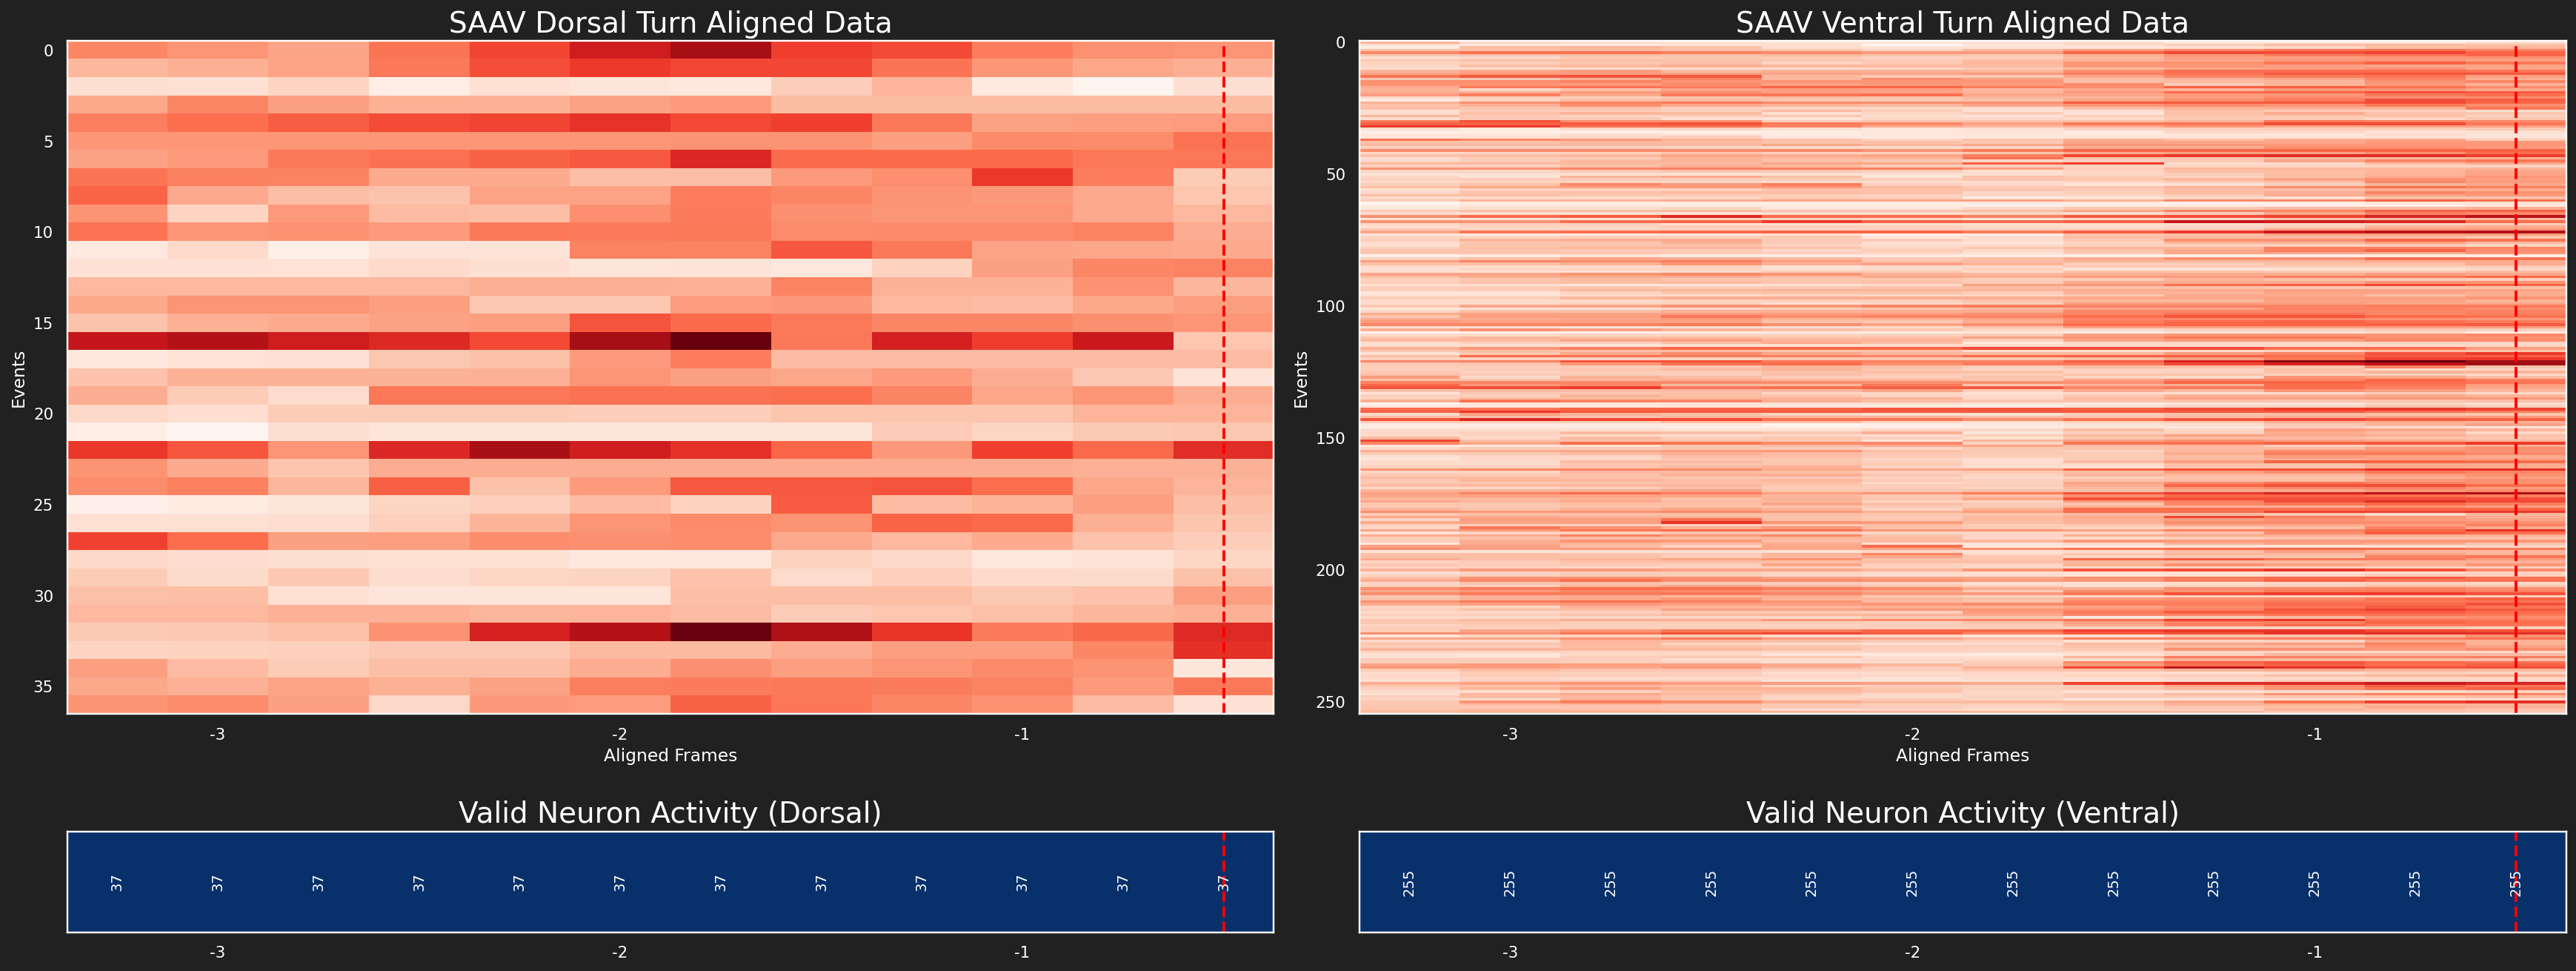

In [8]:
data = fixed_data

plt.figure(figsize=(25, 12), dpi=140)
ax1 = plt.subplot(2, 2, 1)
plt.imshow(data['positive'][:,:,0], aspect='auto', cmap="Reds")
plt.ylabel("Events")
plt.xlabel("Aligned Frames")
plt.title("SAAV Dorsal Turn Aligned Data", fontsize=20)
plt.axvline(11, color='red', linestyle='--', linewidth=2, label="Reversal End")

ax2 = plt.subplot(2, 2, 2)
plt.imshow(data['negative'][:,:,0], aspect='auto', cmap="Reds")
plt.ylabel("Events")
plt.xlabel("Aligned Frames")
plt.title("SAAV Ventral Turn Aligned Data", fontsize=20)
plt.axvline(11, color='red', linestyle='--', linewidth=2, label="Reversal End")


ax3 = plt.subplot(2, 2, 3, sharex=ax1)
valid_counts_dorsal = np.count_nonzero(~np.isnan(data['positive'][:,:,0]), axis=0)
plt.imshow(valid_counts_dorsal.reshape(1, -1), cmap="Blues", aspect=1, vmin=0, vmax=valid_counts_dorsal.max())
plt.yticks([])
plt.axvline(11, color='red', linestyle='--', linewidth=2, label="Reversal End")
plt.title("Valid Neuron Activity (Dorsal)", fontsize=20)
x = np.arange(0, data['positive'].shape[1], 4)+1
plt.xticks(ticks=x, labels=x//4-3)

# Add text labels
for i, count in enumerate(valid_counts_dorsal):
    plt.text(i, 0, str(count), ha='center', va='center', color='white', fontsize=10, rotation=90)

# For the bottom right subplot (Ventral)
ax4 = plt.subplot(2, 2, 4, sharex=ax2)
valid_counts_ventral = np.count_nonzero(~np.isnan(data['negative'][:,:,0]), axis=0)
plt.imshow(valid_counts_ventral.reshape(1, -1), cmap="Blues", aspect=1, vmin=0, vmax=valid_counts_ventral.max())
plt.yticks([])
plt.axvline(11, color='red', linestyle='--', linewidth=2, label="Reversal End")
plt.title("Valid Neuron Activity (Ventral)", fontsize=20)
x = np.arange(0, data['negative'].shape[1], 4)+1
plt.xticks(ticks=x, labels=x//4-3)

# Add text labels
for i, count in enumerate(valid_counts_ventral):
    plt.text(i, 0, str(count), ha='center', va='center', color='white', fontsize=10, rotation=90)

plt.tight_layout()
plt.subplots_adjust(hspace=-0.25)
plt.show()

In [ ]:
import pandas as pd
import numpy as np

data = {}

df1 = pd.read_csv('/data3/prj_rim/Decoding_Data/FlossieAligned/SAAV_Vstart_Dend.csv')
df2 = pd.read_csv('/data3/prj_rim/Decoding_Data/FlossieAligned/SAAV_Dstart_Dend.csv')

np_arr = np.concatenate([df1.to_numpy(), df2.to_numpy()], axis=0)
data['positive'] = np.zeros((np_arr.shape[0], np_arr.shape[1], 3))
data['positive'][:,:,0] = np_arr

df1 = pd.read_csv('/data3/prj_rim/Decoding_Data/FlossieAligned/HC_Vstart_Dend.csv')
df2 = pd.read_csv('/data3/prj_rim/Decoding_Data/FlossieAligned/HC_Dstart_Dend.csv')

np_arr = np.concatenate([df1.to_numpy(), df2.to_numpy()], axis=0)
data['positive'][:,:,1] = np_arr


df1 = pd.read_csv('/data3/prj_rim/Decoding_Data/FlossieAligned/SAAV_Vstart_Vend.csv')
df2 = pd.read_csv('/data3/prj_rim/Decoding_Data/FlossieAligned/SAAV_Dstart_Vend.csv')

np_arr = np.concatenate([df1.to_numpy(), df2.to_numpy()], axis=0)

data['negative'] = np.zeros((np_arr.shape[0], np_arr.shape[1], 3))
data['negative'][:,:,0] = np_arr

df1 = pd.read_csv('/data3/prj_rim/Decoding_Data/FlossieAligned/HC_Vstart_Vend.csv')
df2 = pd.read_csv('/data3/prj_rim/Decoding_Data/FlossieAligned/HC_Dstart_Vend.csv')

np_arr = np.concatenate([df1.to_numpy(), df2.to_numpy()], axis=0)
data['negative'][:,:,1] = np_arr

#
display_data['positive'] = data['positive']#[:,:50]
display_data['negative'] = data['negative']#[:,:50]


neuron = "SAAV"
positive_mean = np.nanmean(display_data['positive'], axis=0)
positive_std = np.nanstd(display_data['positive'], axis=0) / 4

negative_mean = np.nanmean(display_data['negative'], axis=0)
negative_std = np.nanstd(display_data['negative'], axis=0) / 4

plt.figure(figsize=(15, 8))

plt.plot(positive_mean[:, 0], label=f"{neuron} into Dorsal", c=pos_color)
plt.fill_between(range(len(positive_mean)), positive_mean[:, 0] - positive_std[:, 0], positive_mean[:, 0] + positive_std[:, 0], alpha=0.3, color=pos_color)

plt.plot(negative_mean[:, 0], label=f"{neuron} into Ventral", c=neg_color)
plt.fill_between(range(len(negative_mean)), negative_mean[:, 0] - negative_std[:, 0], negative_mean[:, 0] + negative_std[:, 0], alpha=0.3, color=neg_color)

plt.plot(positive_mean[:, 1]-2, c=pos_color, linestyle='--', label="HC into Dorsal")
plt.fill_between(range(len(positive_mean)), positive_mean[:, 1] - positive_std[:, 1] - 2, positive_mean[:, 1] + positive_std[:, 1] - 2, alpha=0.3, color=pos_color)

plt.plot(negative_mean[:, 1]-2, c=neg_color, linestyle='--', label="HC into Ventral")
plt.fill_between(range(len(negative_mean)), negative_mean[:, 1] - negative_std[:, 1] - 2, negative_mean[:, 1] + negative_std[:, 1] - 2, alpha=0.3, color=neg_color)
plt.axvline(49, color='gray', linestyle='--', linewidth=2, label="Reversal Start")



x = np.arange(0, len(positive_mean), 4)+1
plt.xticks(ticks=x, labels=x//4)

plt.legend(loc='upper left')
plt.ylabel("Z-Scored Activity")
plt.grid(axis='x')
plt.xlabel("Head Swings")
plt.title("SAAV Start of Reversal ETAs")
plt.ylim(-3, 1.5)
plt.show()


In [ ]:
plt.figure(figsize=(35, 20), dpi=140)
ax1 = plt.subplot(2, 2, 1)
plt.imshow(data['positive'][:,:,0], aspect='auto', cmap="Reds")
plt.ylabel("Events")
plt.xlabel("Aligned Frames")
plt.title("SAAV Dorsal Turn Aligned Data", fontsize=20)
plt.axvline(49, color='red', linestyle='--', linewidth=2, label="Reversal End")
x = np.arange(0, data['positive'].shape[1], 4)+1
plt.xticks(ticks=x, labels=x//4-12)

ax2 = plt.subplot(2, 2, 2)
plt.imshow(data['negative'][:,:,0], aspect='auto', cmap="Reds")
plt.ylabel("Events")
plt.xlabel("Aligned Frames")
plt.title("SAAV Ventral Turn Aligned Data", fontsize=20)
plt.axvline(49, color='red', linestyle='--', linewidth=2, label="Reversal End")
x = np.arange(0, data['negative'].shape[1], 4)+1
plt.xticks(ticks=x, labels=x//4-12)


ax3 = plt.subplot(2, 2, 3, sharex=ax1)
valid_counts_dorsal = np.count_nonzero(~np.isnan(data['positive'][:,:,0]), axis=0)
plt.imshow(valid_counts_dorsal.reshape(1, -1), cmap="Blues", aspect=5)
plt.yticks([])
plt.axvline(49, color='red', linestyle='--', linewidth=2, label="Reversal End")
plt.title("Valid Neuron Activity (Dorsal)", fontsize=20)
x = np.arange(0, data['positive'].shape[1], 4)+1
plt.xticks(ticks=x, labels=x//4-12)

# Add text labels
for i, count in enumerate(valid_counts_dorsal):
    plt.text(i, 0, str(count), ha='center', va='center', color='black', fontsize=10, rotation=90)

# For the bottom right subplot (Ventral)
ax4 = plt.subplot(2, 2, 4, sharex=ax2)
valid_counts_ventral = np.count_nonzero(~np.isnan(data['negative'][:,:,0]), axis=0)
plt.imshow(valid_counts_ventral.reshape(1, -1), cmap="Blues", aspect=5)
plt.yticks([])
plt.axvline(49, color='red', linestyle='--', linewidth=2, label="Reversal End")
plt.title("Valid Neuron Activity (Ventral)", fontsize=20)
x = np.arange(0, data['negative'].shape[1], 4)+1
plt.xticks(ticks=x, labels=x//4-12)

# Add text labels
for i, count in enumerate(valid_counts_ventral):
    plt.text(i, 0, str(count), ha='center', va='center', color='black', fontsize=10, rotation=90)

plt.tight_layout()
plt.subplots_adjust(hspace=-0.3)
plt.show()

In [ ]:
display_data = {}
display_data['positive'] = data['positive'][:,49:61]
display_data['negative'] = data['negative'][:,49:61]


neuron = "SAAV"
positive_mean = np.nanmean(display_data['positive'], axis=0)
positive_std = np.nanstd(display_data['positive'], axis=0) / 4

negative_mean = np.nanmean(display_data['negative'], axis=0)
negative_std = np.nanstd(display_data['negative'], axis=0) / 4

plt.figure(figsize=(15, 8))

plt.plot(positive_mean[:, 0], label=f"{neuron} into Dorsal", c=pos_color)
plt.fill_between(range(len(positive_mean)), positive_mean[:, 0] - positive_std[:, 0], positive_mean[:, 0] + positive_std[:, 0], alpha=0.3, color=pos_color)

plt.plot(negative_mean[:, 0], label=f"{neuron} into Ventral", c=neg_color)
plt.fill_between(range(len(negative_mean)), negative_mean[:, 0] - negative_std[:, 0], negative_mean[:, 0] + negative_std[:, 0], alpha=0.3, color=neg_color)

plt.plot(positive_mean[:, 1], c=pos_color, linestyle='--', label="HC into Dorsal")
plt.fill_between(range(len(positive_mean)), positive_mean[:, 1] - positive_std[:, 1], positive_mean[:, 1] + positive_std[:, 1], alpha=0.3, color=pos_color)

plt.plot(negative_mean[:, 1], c=neg_color, linestyle='--', label="HC into Ventral")
plt.fill_between(range(len(negative_mean)), negative_mean[:, 1] - negative_std[:, 1], negative_mean[:, 1] + negative_std[:, 1], alpha=0.3, color=neg_color)
plt.axvline(0, color='red', linestyle='--', linewidth=2, label="Reversal Start")


x = np.arange(0, len(positive_mean), 4)
plt.xticks(ticks=x, labels=x//4)

plt.legend(loc='upper left')
plt.ylabel("Z-Scored Activity")
plt.grid(axis='x')
plt.xlabel("Head Swings")
plt.title("SAAV Start of Reversal ETAs (Aligned)")
plt.ylim(-1, 1.5)
plt.show()

In [ ]:
fixed_data = {}
fixed_data['positive'] = jnp.array([ev for ev in display_data['positive'] if not np.isnan(ev).any()])
fixed_data['negative'] = jnp.array([ev for ev in display_data['negative'] if not np.isnan(ev).any()])

print(f"Positive: {fixed_data['positive'].shape}, Negative: {fixed_data['negative'].shape}")

In [ ]:
data = fixed_data

plt.figure(figsize=(25, 12), dpi=140)
ax1 = plt.subplot(2, 2, 1)
plt.imshow(data['positive'][:,:,0], aspect='auto', cmap="Reds")
plt.ylabel("Events")
plt.xlabel("Aligned Frames")
plt.title("SAAV Dorsal Turn Aligned Data", fontsize=20)
plt.axvline(11, color='red', linestyle='--', linewidth=2, label="Reversal End")

ax2 = plt.subplot(2, 2, 2)
plt.imshow(data['negative'][:,:,0], aspect='auto', cmap="Reds")
plt.ylabel("Events")
plt.xlabel("Aligned Frames")
plt.title("SAAV Ventral Turn Aligned Data", fontsize=20)
plt.axvline(11, color='red', linestyle='--', linewidth=2, label="Reversal End")


ax3 = plt.subplot(2, 2, 3, sharex=ax1)
valid_counts_dorsal = np.count_nonzero(~np.isnan(data['positive'][:,:,0]), axis=0)
plt.imshow(valid_counts_dorsal.reshape(1, -1), cmap="Blues", aspect=1, vmin=0, vmax=valid_counts_dorsal.max())
plt.yticks([])
plt.axvline(11, color='red', linestyle='--', linewidth=2, label="Reversal End")
plt.title("Valid Neuron Activity (Dorsal)", fontsize=20)
x = np.arange(0, data['positive'].shape[1], 4)+1
plt.xticks(ticks=x, labels=x//4-3)

# Add text labels
for i, count in enumerate(valid_counts_dorsal):
    plt.text(i, 0, str(count), ha='center', va='center', color='white', fontsize=10, rotation=90)

# For the bottom right subplot (Ventral)
ax4 = plt.subplot(2, 2, 4, sharex=ax2)
valid_counts_ventral = np.count_nonzero(~np.isnan(data['negative'][:,:,0]), axis=0)
plt.imshow(valid_counts_ventral.reshape(1, -1), cmap="Blues", aspect=1, vmin=0, vmax=valid_counts_ventral.max())
plt.yticks([])
plt.axvline(11, color='red', linestyle='--', linewidth=2, label="Reversal End")
plt.title("Valid Neuron Activity (Ventral)", fontsize=20)
x = np.arange(0, data['negative'].shape[1], 4)+1
plt.xticks(ticks=x, labels=x//4-3)

# Add text labels
for i, count in enumerate(valid_counts_ventral):
    plt.text(i, 0, str(count), ha='center', va='center', color='white', fontsize=10, rotation=90)

plt.tight_layout()
plt.subplots_adjust(hspace=-0.25)
plt.show()

In [ ]:
neuron_data = {}

for class_idx, neuron_class in enumerate(neuron_classes):
    print(f"Class: {neuron_class} ({class_idx+1}/{len(neuron_classes)})")
    data_dict = h5_to_dict(file_paths[class_idx])

    data = {}
    data["positive"] = jnp.array(data_dict[pos_cat_key])
    data["negative"] =  jnp.array(data_dict[neg_cat_key])

    neuron_data[neuron_class] = data

neuron = "SAAV"

fixed_data = neuron_data[neuron]
positive_mean = jnp.mean(fixed_data, axis=0)
positive_std = jnp.std(fixed_data, axis=0) / 4

negative_mean = jnp.mean(fixed_data, axis=0)
negative_std = jnp.std(fixed_data, axis=0) / 4

plt.figure(figsize=(15, 8))

plt.plot(positive_mean[:, 0], label=f"{neuron} into Dorsal", color=pos_color)
plt.fill_between(range(len(positive_mean)), positive_mean[:, 0] - positive_std[:, 0], positive_mean[:, 0] + positive_std[:, 0], alpha=0.3, color=pos_color)

plt.plot(negative_mean[:, 0], label=f"{neuron} into Ventral", color=neg_color)
plt.fill_between(range(len(negative_mean)), negative_mean[:, 0] - negative_std[:, 0], negative_mean[:, 0] + negative_std[:, 0], alpha=0.3, color=neg_color)

plt.plot(positive_mean[:, 1], c=pos_color, linestyle='--', label="HC into Dorsal")
plt.fill_between(range(len(positive_mean)), positive_mean[:, 1] - positive_std[:, 1], positive_mean[:, 1] + positive_std[:, 1], alpha=0.3, color=pos_color)

plt.plot(negative_mean[:, 1], c=neg_color, linestyle='--', label="HC into Ventral")
plt.fill_between(range(len(negative_mean)), negative_mean[:, 1] - negative_std[:, 1], negative_mean[:, 1] + negative_std[:, 1], alpha=0.3, color=neg_color)

plt.axvline(0, color='red', linestyle='--', linewidth=2, label="Reversal Start")


x = jnp.arange(0, len(positive_mean))
plt.xticks(ticks=x, labels=x)

plt.legend(loc='upper left')
plt.ylabel("Z-Scored Activity")
plt.grid()
plt.xlabel("Time (Frames)")
plt.title("SAAV End of Reversal ETAs (Not Aligned)")
plt.ylim(-1, 1.5)
plt.show()

Positive Data Shape: (37, 12, 3), Negative Data Shape: (255, 12, 3)
Train_xs: (592, 5, 3), Train_ys: (592, 1)
Truncated len: 592
Batch Size: 16 n_batches: 37


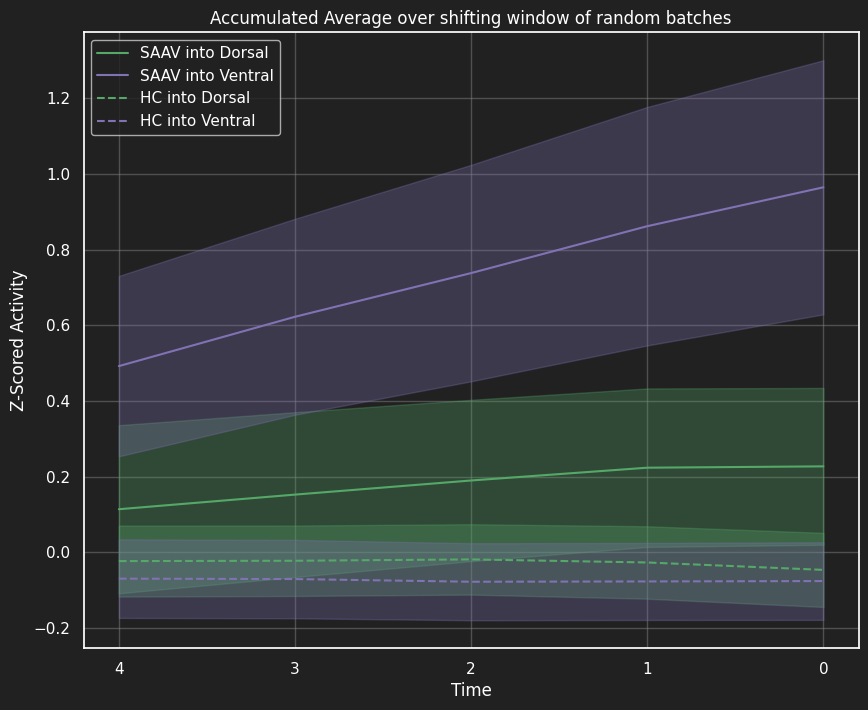

In [9]:
from util import establish_batches

# data = neuron_data['SAAV']
data = fixed_data
    
# Shuffle the positive category data"
key, subkey = jrandom.split(key)
data["positive"], _ = shuffle_data(data["positive"], subkey)

# Shuffle the negative category data
key, subkey = jrandom.split(key)
data["negative"], _ = shuffle_data(data["negative"], subkey)

print(f"Positive Data Shape: {data['positive'].shape}, Negative Data Shape: {data['negative'].shape}")

min_len = min(data["positive"].shape[0], data["negative"].shape[0])
key, subkey = jrandom.split(key)
batched = establish_batches(subkey, data, min_len)

pos_cat = []
neg_cat = []

for x, y in zip(*batched):
    for idx in range(x.shape[0]):
        if y[idx] == 1:
            pos_cat.append(x[idx])
        else:
            neg_cat.append(x[idx])
            
pos_cat = jnp.array(pos_cat)
neg_cat = jnp.array(neg_cat)

neuron = "SAAV"
positive_mean = jnp.mean(pos_cat, axis=(0))
positive_std = jnp.std(pos_cat, axis=(0)) / 4

negative_mean = jnp.mean(neg_cat, axis=(0))
negative_std = jnp.std(neg_cat, axis=(0)) / 4

plt.figure(figsize=(10, 8))

plt.plot(positive_mean[:, 0], label=f"{neuron} into Dorsal", color=pos_color)
plt.fill_between(range(len(positive_mean)), positive_mean[:, 0] - positive_std[:, 0], positive_mean[:, 0] + positive_std[:, 0], alpha=0.3, color=pos_color)

plt.plot(negative_mean[:, 0], label=f"{neuron} into Ventral", color=neg_color)
plt.fill_between(range(len(negative_mean)), negative_mean[:, 0] - negative_std[:, 0], negative_mean[:, 0] + negative_std[:, 0], alpha=0.3, color=neg_color)

plt.plot(positive_mean[:, 1], c=pos_color, linestyle='--', label="HC into Dorsal")
plt.fill_between(range(len(positive_mean)), positive_mean[:, 1] - positive_std[:, 1], positive_mean[:, 1] + positive_std[:, 1], alpha=0.3, color=pos_color)

plt.plot(negative_mean[:, 1], c=neg_color, linestyle='--', label="HC into Ventral")
plt.fill_between(range(len(negative_mean)), negative_mean[:, 1] - negative_std[:, 1], negative_mean[:, 1] + negative_std[:, 1], alpha=0.3, color=neg_color)

x = jnp.arange(0, len(positive_mean))
plt.xticks(ticks=x, labels=x[::-1])

plt.legend(loc='upper left')
plt.ylabel("Z-Scored Activity")
plt.grid()
plt.xlabel("Time")
plt.title("Accumulated Average over shifting window of random batches")
plt.show()

In [10]:
def main(key, data):
    
    # Shuffle the positive category data
    key, subkey = jrandom.split(key)
    data["positive"], _ = shuffle_data(data["positive"], subkey)

    # Shuffle the negative category data
    key, subkey = jrandom.split(key)
    data["negative"], _ = shuffle_data(data["negative"], subkey)

    # min_len = min(data["positive"].shape[0], data["negative"].shape[0])
    # data['positive'] = data['positive'][:min_len]
    # data['negative'] = data['negative'][:min_len]
    
    print(f"Positive Data Shape: {data['positive'].shape}, Negative Data Shape: {data['negative'].shape}")
    
    fold = partial(single_fold, data=data)
    
    key, subkey = jrandom.split(key)
    subkeys = jrandom.split(subkey, k_folds*(k_folds-1))
    fold_results = jax.vmap(lambda i: jax.vmap(lambda j: fold(subkeys[i*(k_folds-1)+j], i, j))(jnp.arange(k_folds-1)))(jnp.arange(k_folds))
    
    total_data_points = min(data["positive"].shape[0], data["negative"].shape[0]) * 2
    
    results = {}
    results['results'] = fold_results
    results['n_total'] = total_data_points

    return results

print(f"Hyperparams: L2 Epsilon: {l2_eps:.0e}, Hidden Size: {hidden_size}, Batch Size: {batch_size} Time Range: {time_range}\n")
key, subkey = jrandom.split(key)
model_results = main(subkey, fixed_data)
results = model_results['results']

Hyperparams: L2 Epsilon: 0e+00, Hidden Size: 6, Batch Size: 16 Time Range: 5

Positive Data Shape: (37, 12, 3), Negative Data Shape: (255, 12, 3)
Train_xs: (336, 5, 2), Train_ys: (336, 1)
Truncated len: 336
Batch Size: 16 n_batches: 21
Epoch: 20
Epoch: 40
Epoch: 60
Epoch: 80
Epoch: 100
Epoch: 120
Epoch: 140
Epoch: 160
Epoch: 180
Epoch: 200
Epoch: 220
Epoch: 240
Epoch: 260
Epoch: 280
Epoch: 300
Epoch: 320
Epoch: 340
Epoch: 360
Epoch: 380
Epoch: 400
Epoch: 420
Epoch: 440
Epoch: 460
Epoch: 480
Epoch: 500


Eval Ratio:    1.0763, Data Ratio:    6.8919
Positive Test: 0.6203, Negative Test: 0.5763
Test Eval:     0.5819, Control Eval:  0.4839
Min Val Loss Test:  0.6170, Min Val Loss Control: 0.6733
Hyper Params:  HS: 6 BS: 16 TR: 5 L2: 0E+00


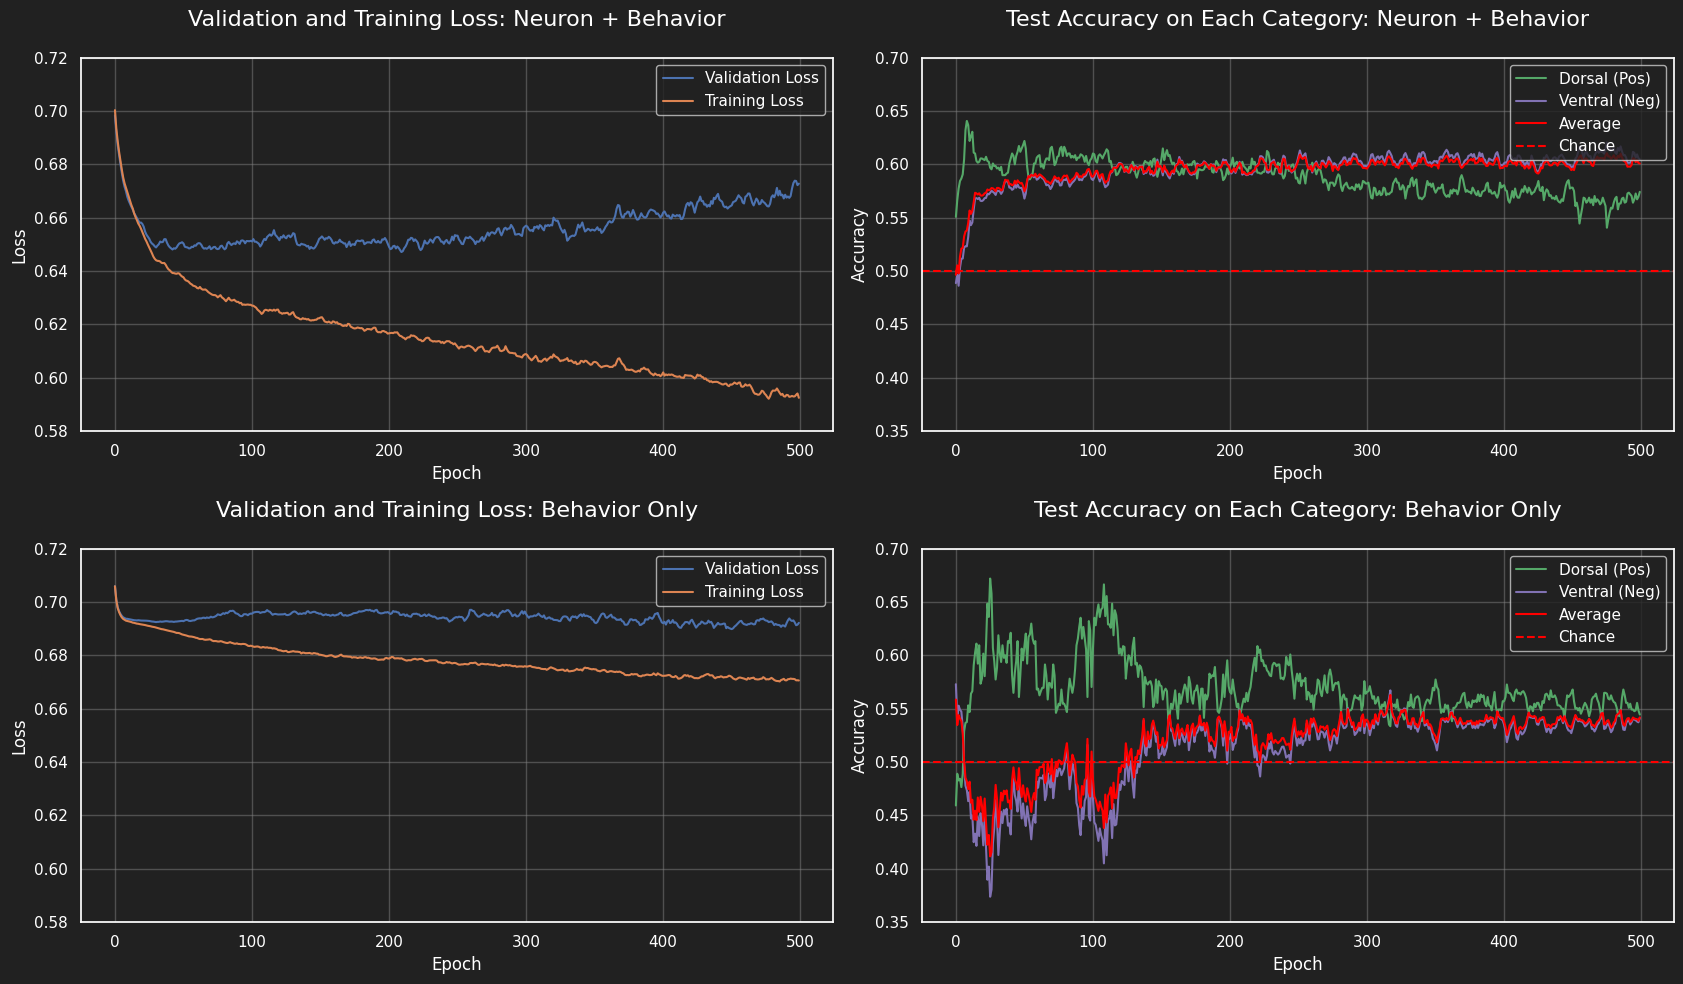

In [11]:
plt.figure(figsize=(17, 10))
shaded_alpha = 0.2

pos_weight = data['positive'].shape[0] / (data['positive'].shape[0] + data['negative'].shape[0])
neg_weight = data['negative'].shape[0] / (data['positive'].shape[0] + data['negative'].shape[0])
pos_weight, neg_weight


for channel in [0, 1]:
    plt.subplot(2, 2, 1 + channel*2)
    # for i in range(results['ValidLoss'].shape[0]):
    #     plt.plot(jnp.mean(results['ValidLoss'][i,:,channel], axis=(0)), c="C0", alpha=shaded_alpha)
    #     plt.plot(jnp.mean(results['TrainLoss'][i,:,channel], axis=(0)), c="C1", alpha=shaded_alpha)

    plt.plot(jnp.mean(results['ValidLoss'][:,:,channel], axis=(0,1)),label="Validation Loss", c="C0")
    plt.plot(jnp.mean(results['TrainLoss'][:,:,channel], axis=(0,1)),label="Training Loss", c="C1")
    plt.legend(loc='upper right')
    plt.grid()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Validation and Training Loss: {"Neuron + Behavior" if channel==0 else "Behavior Only"}\n", fontsize=16)
    plt.ylim(0.58, 0.72)

    plt.subplot(2, 2, 2 + channel*2)
    # for i in range(results['TestPos'].shape[0]):
    #     plt.plot(jnp.mean(results['TestPos'][i,:,channel], axis=(0)), c=pos_color, alpha=shaded_alpha)
    #     plt.plot(jnp.mean(results['TestNeg'][i,:,channel], axis=(0)), c=neg_color, alpha=shaded_alpha)
    #     plt.plot((jnp.mean(results['TestPos'][i,:,channel], axis=(0)) + jnp.mean(results['TestNeg'][i,:,channel], axis=(0)))/2, c="red", alpha=shaded_alpha)

    plt.plot(jnp.mean(results['TestPos'][:,:,channel], axis=(0,1)),label="Dorsal (Pos)", c=pos_color)
    plt.plot(jnp.mean(results['TestNeg'][:,:,channel], axis=(0,1)),label="Ventral (Neg)", c=neg_color)
    plt.plot((jnp.mean(results['TestPos'][:,:,channel], axis=(0,1)) * pos_weight + jnp.mean(results['TestNeg'][:,:,channel], axis=(0,1)) * neg_weight), label="Average", c="red")
    plt.axhline(y=0.5, c="red", linestyle="--", label="Chance")
    plt.legend(loc='upper right')
    plt.grid()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.ylim(0.35, 0.7)
    plt.title(f"Test Accuracy on Each Category: {"Neuron + Behavior" if channel==0 else "Behavior Only"}\n", fontsize=16)

eval_epoch = jnp.argmin(results['ValidLoss'], axis=-1)
eval_results_pos = jax.vmap(jax.vmap(jax.vmap(lambda epoch, acc: acc[epoch])))(eval_epoch, results['TestPos'])
eval_results_neg = jax.vmap(jax.vmap(jax.vmap(lambda epoch, acc: acc[epoch])))(eval_epoch, results['TestNeg'])

data_ratio = data['negative'].shape[0] / data['positive'].shape[0]

pos_test, neg_test = jnp.mean(eval_results_pos, axis=(0,1))[0], jnp.mean(eval_results_neg, axis=(0,1))[0]

eval_ratio = pos_test / neg_test
test_eval = (jnp.mean(eval_results_pos, axis=(0,1))[0] * pos_weight + jnp.mean(eval_results_neg, axis=(0,1))[0] * neg_weight)
control_eval = (jnp.mean(eval_results_pos, axis=(0,1))[1] * pos_weight + jnp.mean(eval_results_neg, axis=(0,1))[1] * neg_weight)

min_val_loss = jnp.mean(jnp.min(results['ValidLoss'], axis=-1), axis=(0,1))

print(f"Eval Ratio:    {eval_ratio:.4f}, Data Ratio:    {data_ratio:.4f}")
print(f"Positive Test: {pos_test:.4f}, Negative Test: {neg_test:.4f}")
print(f"Test Eval:     {test_eval:.4f}, Control Eval:  {control_eval:.4f}")
print(f"Min Val Loss Test:  {min_val_loss[0]:.4f}, Min Val Loss Control: {min_val_loss[1]:.4f}")
print(f"Hyper Params:  HS: {hidden_size} BS: {batch_size} TR: {time_range} L2: {l2_eps:.0E}")

plt.tight_layout()
plt.show()


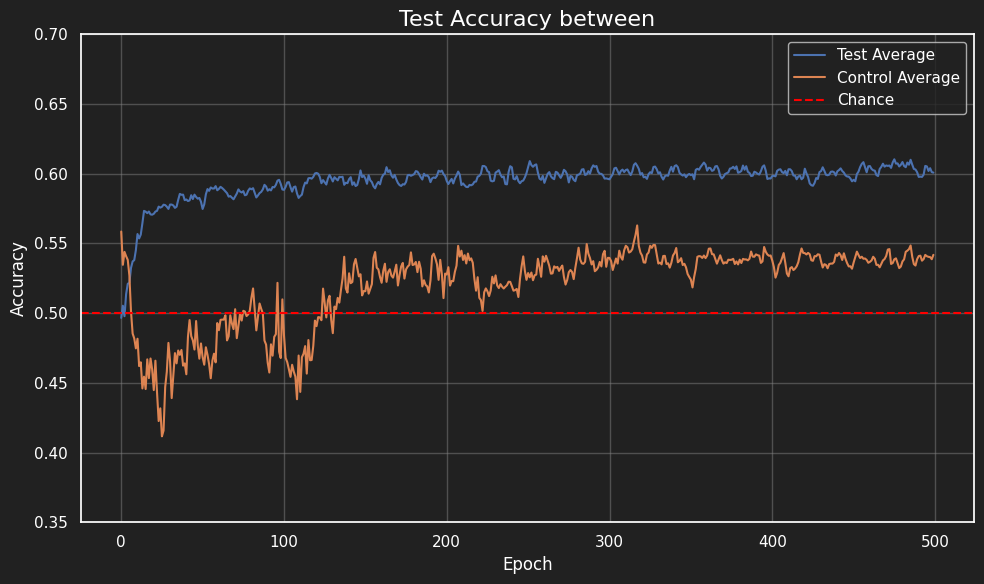

In [12]:
plt.figure(figsize=(10, 6))
shaded_alpha = 0.2

test_mean = jnp.mean((results['TestPos'][:,:,0] * pos_weight + results['TestNeg'][:,:,0] * neg_weight), axis=(0,1))
test_std  = jnp.std((results['TestPos'][:,:,0] * pos_weight + results['TestNeg'][:,:,0] * neg_weight), axis=(0,1))
control_mean = jnp.mean((results['TestPos'][:,:,1] * pos_weight + results['TestNeg'][:,:,1] * neg_weight), axis=(0,1))
control_std = jnp.std((results['TestPos'][:,:,1] * pos_weight + results['TestNeg'][:,:,1] * neg_weight), axis=(0,1))

plt.plot(test_mean, label="Test Average", c="C0")
# plt.fill_between(range(len(test_mean)), test_mean - test_std, test_mean + test_std, alpha=0.3, color="C0")
plt.plot(control_mean, label="Control Average", c="C1")
# plt.fill_between(range(len(control_mean)), control_mean - control_std, control_mean + control_std, alpha=0.3, color="C1")
plt.axhline(y=0.5, c="red", linestyle="--", label="Chance")
plt.legend(loc='upper right')
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0.35, 0.7)
plt.title(f"Test Accuracy between", fontsize=16)


plt.tight_layout()
plt.show()


In [13]:
n = fixed_data['positive'].shape[0] + fixed_data['negative'].shape[0]

In [ ]:
from scipy.stats import binom

# n = neuron_results['SAAV']['n_total']
# n = 50000
k = int(test_eval * n)
p = 0.5

p_value = 1 - binom.cdf(k, n, p)

print(f"n: {n}, k: {k}, Accuracy: {test_eval:.4f}, p-value: {p_value:.4f}")

In [14]:
def index_dist(key, index, n, n_samples=500000):
    def sample(key, _):
        key, subkey = jrandom.split(key)
        subkeys = jrandom.split(subkey, n)
        samples = jax.vmap(lambda sk: jrandom.categorical(sk, jnp.full((n+1,),1.0)))(subkeys)
        sampled_index = jnp.sum(jnp.where(samples > index, 0, 1))

        return key, sampled_index

    _, samples = jax.lax.scan(sample, key, None, length=n_samples)
    return samples

In [15]:
n_eval = int(test_eval * n)
n_control = int(control_eval * n)

# print(f"{neuron_class} Test Eval: {test_eval:.4f} ({n_eval}/{n}), Control Eval: {control_eval:.4f} ({n_control}/{n})")

key, subkey = jrandom.split(key)
jax.disable_jit(True)
eval_sampled = index_dist(subkey, n_eval, n)
key, subkey = jrandom.split(key)
control_sampled = index_dist(subkey, n_control, n)

sample_diff = eval_sampled - control_sampled
pval = jnp.sum(jnp.where(sample_diff < 0, 1, 0)) / sample_diff.shape[0]

# eval_dict = {'test_eval': test_eval, 
#                             'control_eval': control_eval, 
#                             'test_eval_sl': float(jnp.percentile(eval_sampled / n, 2.5)), 
#                             'control_eval_sl': float(jnp.percentile(control_sampled / n, 2.5)), 
#                             'test_eval_su': float(jnp.percentile(eval_sampled / n, 97.5)), 
#                             'control_eval_su': float(jnp.percentile(control_sampled / n, 97.5)), 
#                             'p_value': float(pval)}

# violin_eval_dict = {'test_eval_samples': jnp.array(eval_sampled * (100.0 / n), dtype=int), 
#                             'control_eval_samples': jnp.array(control_sampled * (100.0 / n), dtype=int), 
#                             'p_value': float(pval)}

print(f"p-value: {pval:.6f}\n")

p-value: 0.009212



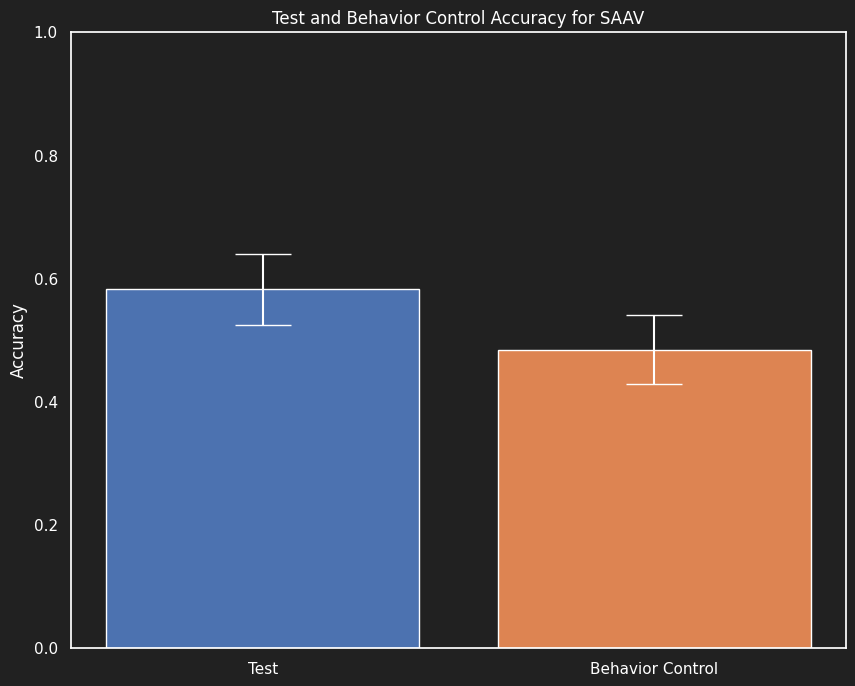

In [16]:
plt.figure(figsize=(10, 8))
plt.bar(["Test", "Behavior Control"], [test_eval, control_eval], color=['C0', 'C1'])
plt.errorbar(["Test", "Behavior Control"], [test_eval, control_eval], yerr=[test_eval - jnp.percentile(eval_sampled / n, 2.5), control_eval - jnp.percentile(control_sampled / n, 2.5)], capsize=20, fmt=',', color='white')
plt.ylabel("Accuracy")
plt.ylim(0.0, 1)
plt.title(f"Test and Behavior Control Accuracy for SAAV")
plt.savefig('TestvsControlDVWeight.eps', format='eps')
plt.show()

In [ ]:
from config import hidden_size, learning_rate, batch_size

# dict_to_h5(f'{save_dir_path}/{save_file_name}.h5', neuron_results, overwrite=False)
dict_to_h5(f'{save_dir_path}/{save_file_name}_{hidden_size:02d}_{learning_rate:.0e}_{batch_size:02d}.h5', neuron_results, overwrite=True)